In [12]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct

In [5]:
NUM_TEMPORAL_SAMPLES = 100
SAMPLE_RATE = 16000


def extract_rms_contour(audio_np):
    """Extract RMS energy contour with fixed number of samples"""
    # Use frame length of 1024 samples (64ms at 16kHz)
    frame_length = 1024
    hop_length = frame_length // 4

    # Calculate RMS for each frame
    rms = librosa.feature.rms(
        y=audio_np, frame_length=frame_length, hop_length=hop_length, center=True
    )[0]  # Shape: (n_frames,)

    # Resample to fixed number of samples
    if len(rms) != NUM_TEMPORAL_SAMPLES:
        # Use linear interpolation to get exactly num_temporal_samples
        from scipy.interpolate import interp1d

        if len(rms) > 1:
            x_old = np.linspace(0, 1, len(rms))
            x_new = np.linspace(0, 1, NUM_TEMPORAL_SAMPLES)
            f = interp1d(
                x_old,
                rms,
                kind="linear",
                bounds_error=False,
                fill_value="extrapolate",
            )
            rms = f(x_new)
        else:
            # If only one frame, repeat it
            rms = np.full(NUM_TEMPORAL_SAMPLES, rms[0] if len(rms) > 0 else 0.0)

    # Normalize RMS to [0, 1] range using robust normalization
    rms_normalized = rms / (np.percentile(rms, 95) + 1e-8)
    rms_normalized = np.clip(rms_normalized, 0, 1)

    return rms_normalized.astype(np.float32)


def extract_pitch_contour(audio_np):
    """Extract F0 pitch contour with fixed number of samples"""
    # Use librosa's piptrack for pitch estimation
    frame_length = 1024
    hop_length = frame_length // 4

    try:
        # Extract pitch using librosa's yin algorithm (more robust than piptrack)
        f0 = librosa.yin(
            audio_np,
            fmin=80,  # Minimum frequency (Hz) - good for human voice
            fmax=400,  # Maximum frequency (Hz) - good for human voice
            sr=SAMPLE_RATE,
            frame_length=frame_length,
            hop_length=hop_length,
        )
    except:
        # Fallback to piptrack if yin fails
        pitches, magnitudes = librosa.piptrack(
            y=audio_np,
            sr=SAMPLE_RATE,
            threshold=0.1,
            fmin=80,
            fmax=400,
            frame_length=frame_length,
            hop_length=hop_length,
        )
        # Select the pitch with highest magnitude at each frame
        f0 = []
        for t in range(pitches.shape[1]):
            index = magnitudes[:, t].argmax()
            pitch = pitches[index, t] if magnitudes[index, t] > 0.1 else 0
            f0.append(pitch)
        f0 = np.array(f0)

    # Handle unvoiced regions (set to 0) and smooth the contour
    f0 = np.where(f0 < 80, 0, f0)  # Remove very low frequencies

    # Resample to fixed number of samples
    if len(f0) != NUM_TEMPORAL_SAMPLES:
        from scipy.interpolate import interp1d

        if len(f0) > 1:
            x_old = np.linspace(0, 1, len(f0))
            x_new = np.linspace(0, 1, NUM_TEMPORAL_SAMPLES)
            f = interp1d(
                x_old,
                f0,
                kind="linear",
                bounds_error=False,
                fill_value="extrapolate",
            )
            f0 = f(x_new)
        else:
            f0 = np.full(NUM_TEMPORAL_SAMPLES, f0[0] if len(f0) > 0 else 0.0)

    # Normalize pitch: convert to log scale for voiced regions, normalize to [0, 1]
    f0_log = np.where(f0 > 0, np.log(f0 + 1e-8), 0)
    if f0_log.max() > f0_log.min():
        f0_normalized = (f0_log - f0_log.min()) / (f0_log.max() - f0_log.min() + 1e-8)
    else:
        f0_normalized = f0_log

    return f0_normalized.astype(np.float32)


def extract_spectral_centroid_contour(audio_np):
    """Extract spectral centroid contour with fixed number of samples"""
    frame_length = 1024
    hop_length = frame_length // 4

    # Calculate spectral centroid
    spectral_centroids = librosa.feature.spectral_centroid(
        y=audio_np, sr=SAMPLE_RATE, hop_length=hop_length, n_fft=frame_length
    )[0]  # Shape: (n_frames,)

    # Resample to fixed number of samples
    if len(spectral_centroids) != NUM_TEMPORAL_SAMPLES:
        from scipy.interpolate import interp1d

        if len(spectral_centroids) > 1:
            x_old = np.linspace(0, 1, len(spectral_centroids))
            x_new = np.linspace(0, 1, NUM_TEMPORAL_SAMPLES)
            f = interp1d(
                x_old,
                spectral_centroids,
                kind="linear",
                bounds_error=False,
                fill_value="extrapolate",
            )
            spectral_centroids = f(x_new)
        else:
            spectral_centroids = np.full(
                NUM_TEMPORAL_SAMPLES,
                spectral_centroids[0] if len(spectral_centroids) > 0 else 0.0,
            )

    # Normalize spectral centroid to [0, 1] using robust normalization
    # Convert to log scale first to handle the wide range
    sc_log = np.log(spectral_centroids + 1e-8)
    sc_normalized = (sc_log - sc_log.min()) / (sc_log.max() - sc_log.min() + 1e-8)

    return sc_normalized.astype(np.float32)

In [14]:
y, sr = librosa.load(
    "/home/chris/dev/QBV2025/data/Vim_Sketch/references/541_239-xylophone-acoustic_instruments.wav",
    sr=16000,
)
rms = extract_rms_contour(y)
pitch = extract_pitch_contour(y)
spectral_centroid = extract_spectral_centroid_contour(y)

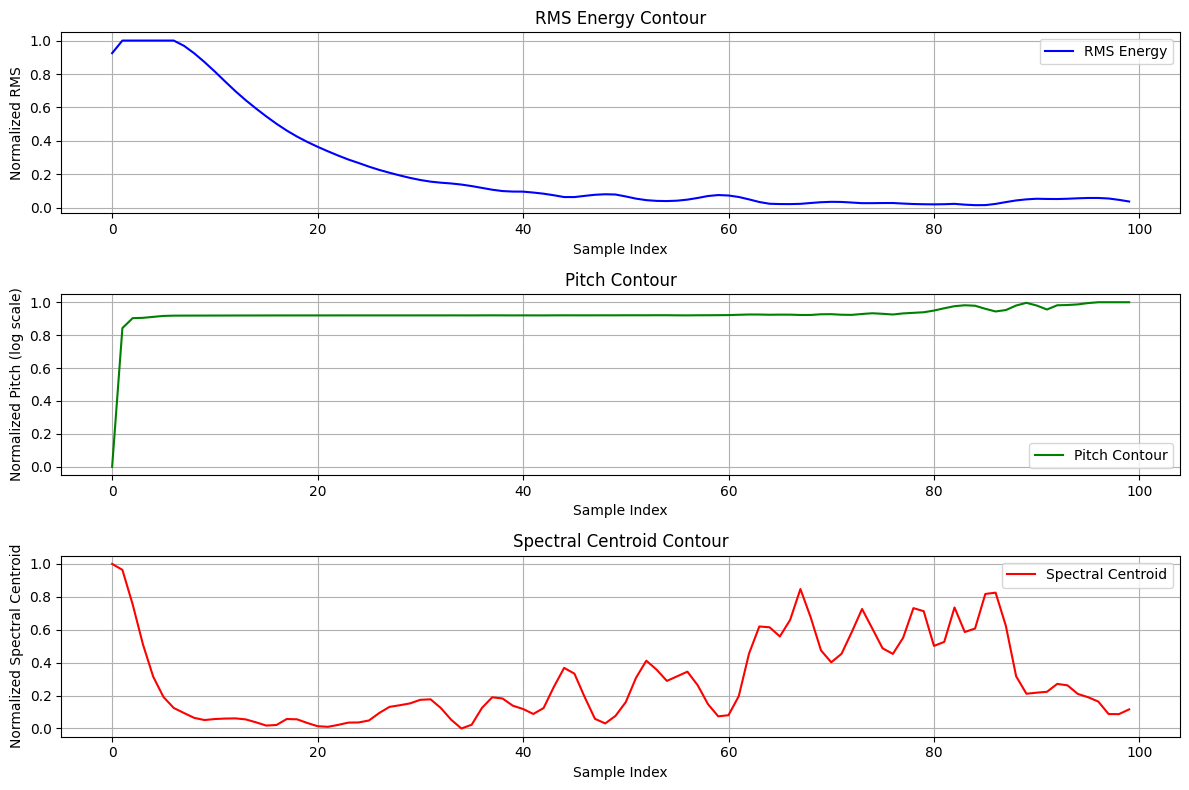

In [15]:
# plot
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(rms, label="RMS Energy", color="blue")
plt.title("RMS Energy Contour")
plt.xlabel("Sample Index")
plt.ylabel("Normalized RMS")
plt.grid()
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(pitch, label="Pitch Contour", color="green")
plt.title("Pitch Contour")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Pitch (log scale)")
plt.grid()
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(spectral_centroid, label="Spectral Centroid", color="red")
plt.title("Spectral Centroid Contour")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Spectral Centroid")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

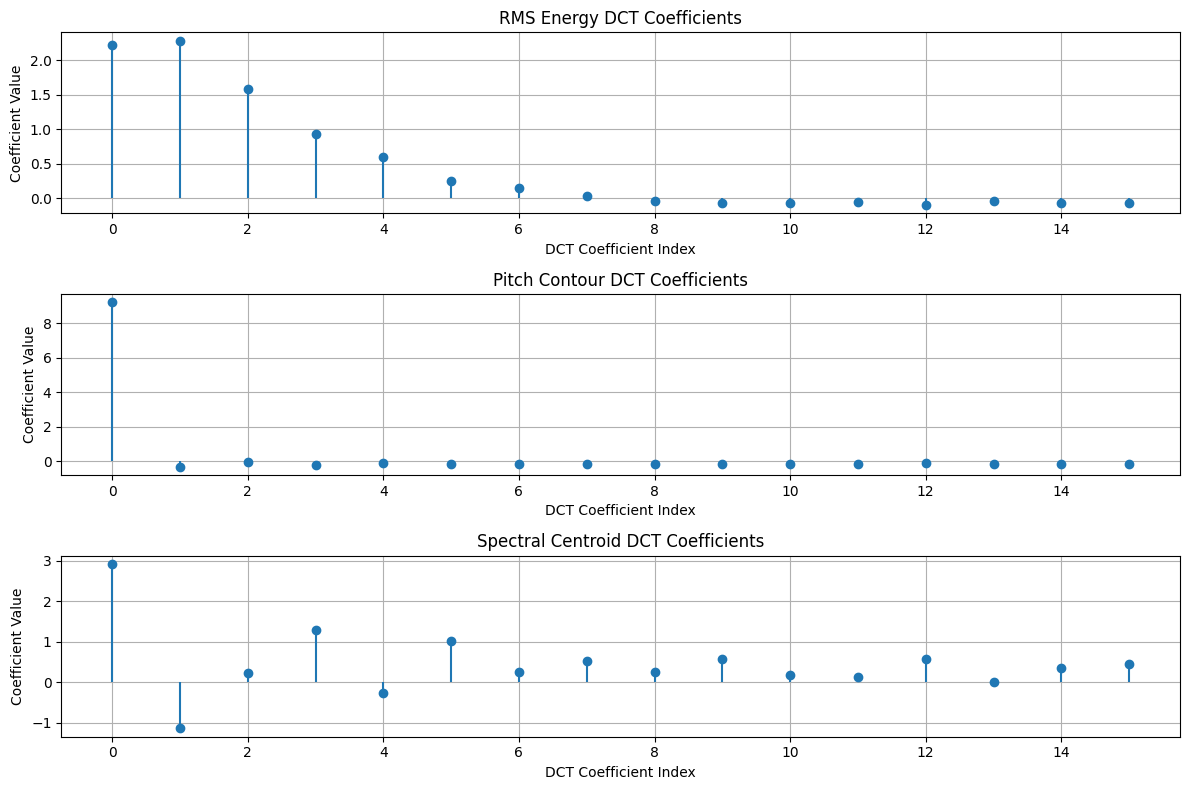

In [18]:
# Compute DCT of the features
NUM_DCT_COEFFS = 16  # Number of DCT coefficients to keep/plot

rms_dct = dct(rms, type=2, norm="ortho")[:NUM_DCT_COEFFS]
pitch_dct = dct(pitch, type=2, norm="ortho")[:NUM_DCT_COEFFS]
spectral_centroid_dct = dct(spectral_centroid, type=2, norm="ortho")[:NUM_DCT_COEFFS]

# Plot DCT coefficients
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.stem(range(NUM_DCT_COEFFS), rms_dct, basefmt=" ")
plt.title("RMS Energy DCT Coefficients")
plt.xlabel("DCT Coefficient Index")
plt.ylabel("Coefficient Value")
plt.grid()

plt.subplot(3, 1, 2)
plt.stem(range(NUM_DCT_COEFFS), pitch_dct, basefmt=" ")
plt.title("Pitch Contour DCT Coefficients")
plt.xlabel("DCT Coefficient Index")
plt.ylabel("Coefficient Value")
plt.grid()

plt.subplot(3, 1, 3)
plt.stem(range(NUM_DCT_COEFFS), spectral_centroid_dct, basefmt=" ")
plt.title("Spectral Centroid DCT Coefficients")
plt.xlabel("DCT Coefficient Index")
plt.ylabel("Coefficient Value")
plt.grid()

plt.tight_layout()
plt.show()